## **IMPORT LIBRARY**

In [126]:
import numpy as np
import pandas as pd                            
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split       
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression     
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier      


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.base import clone
import time

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

## **Loading Data...**

In [127]:
df_gempa = pd.read_csv('earthquake_dataset.csv',header=0)

df_gempa.head()



,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


## **Membaca tipedata**

In [128]:
print("Jumlah baris, kolom:", df_gempa.shape)    
print("\nTipe data:")
print(df_gempa.dtypes)

df_gempa.describe()

Jumlah baris, kolom: (1300, 6)

Tipe data:
magnitude    float64
depth        float64
cdi          float64
mmi          float64
sig          float64
alert         object
dtype: object


,magnitude,depth,cdi,mmi,sig
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.061008,50.321538,6.976154,6.939231,-9.749231
std,0.423738,104.348286,2.244875,1.354774,62.245214
min,6.500000,2.000000,0.000000,1.000000,-128.000000
25%,6.700000,12.000000,6.000000,6.000000,-54.000000
50%,7.000000,19.000000,8.000000,7.000000,-7.000000
75%,7.300000,38.000000,8.000000,8.000000,31.000000
max,8.600000,670.000000,9.000000,9.000000,127.000000


## **Mengubah Alert(Object) Menjadi Numerik**

In [129]:
df_gempa['alert'].unique()




array(['green', 'yellow', 'orange', 'red'], dtype=object)

In [130]:
mapping = {
    'green': 0,
    'yellow': 1,
    'orange': 2,
    'red': 3
}
df_gempa2 = df_gempa
df_gempa2['alert'] = df_gempa2['alert'].map(mapping)

In [131]:
df_gempa2.head(20)

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,0
1,6.9,25.0,4.0,4.0,-33.0,0
2,7.0,579.0,3.0,3.0,-13.0,0
3,7.3,37.0,5.0,5.0,65.0,0
4,6.6,624.0,0.0,2.0,-98.0,0
5,7.0,660.0,4.0,3.0,-13.0,0
6,6.8,630.0,1.0,3.0,-57.0,0
7,6.7,20.0,7.0,6.0,29.0,0
8,6.8,20.0,8.0,7.0,-101.0,1
9,7.6,26.0,9.0,8.0,7.0,1


## **Pembersihan Data : pengecekan Data NULL & Pembersihan Data Duplikat**

In [132]:
print("Jumlah nilai kosong per kolom:\n", df_gempa2.isnull().sum())
print("Jumlah data duplikat:", df_gempa2.duplicated().sum())


Jumlah nilai kosong per kolom:
 magnitude    0
depth        0
cdi          0
mmi          0
sig          0
alert        0
dtype: int64
Jumlah data duplikat: 44


In [133]:
df_gempa3 = df_gempa2
df_gempa3 = df_gempa3.drop_duplicates()

print("Jumlah data duplikat:", df_gempa3.duplicated().sum())

X = df_gempa3.drop(columns=['alert'])
y = df_gempa3['alert']


Jumlah data duplikat: 0


## **Pembagian Data Train Train/TestSplit**

In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.4,      
    random_state=86,   
    stratify=y          
)

print("Ukuran X_train, X_test:", X_train.shape, X_test.shape)

Ukuran X_train, X_test: (753, 5) (503, 5)


##  **Membangun Model Gradient Boosting Classifier dengan Pipeline**

In [135]:
pipe_GBS = Pipeline(steps=[
    ('scaler', StandardScaler()),             
    ('feat_select', SelectKBest()),       
    ('clf', GradientBoostingClassifier(     
        n_estimators=100,        
        learning_rate=0.2,      
        max_depth=3,             
        random_state=86            
    ))
])


In [ ]:
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_gb = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 4]
}


gscv_gb = GridSearchCV(
    pipe_GBS,
    param_grid_gb,
    cv=SKF,
    scoring='f1',       # metrik utama: F1-score
    verbose=1,          # tampilkan progres selama proses
    n_jobs=-1              # gunakan semua core CPU
)

grid_gb.fit(X_train, y_train)

print("Best params (Gradient Boosting):", grid_gb.best_params_)
print("Best score (Gradient Boosting):", grid_gb.best_score_)

c:\Program Files\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(


Best params (Gradient Boosting): {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 200}
Best score (Gradient Boosting): 0.8698896247240618


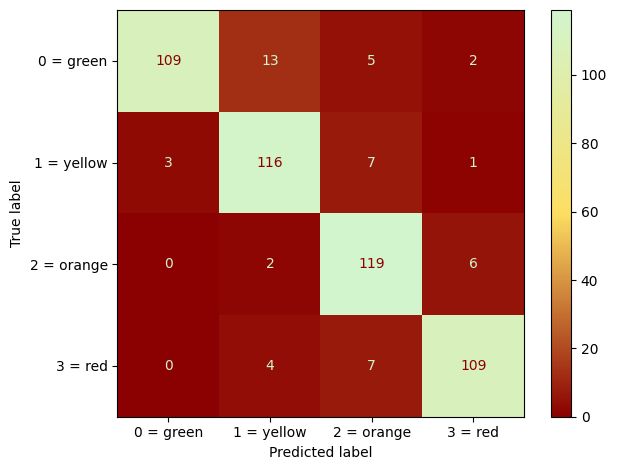

Gradient Boosting Report:

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       129
           1       0.86      0.91      0.89       127
           2       0.86      0.94      0.90       127
           3       0.92      0.91      0.92       120

    accuracy                           0.90       503
   macro avg       0.90      0.90      0.90       503
weighted avg       0.90      0.90      0.90       503



In [143]:
from matplotlib.colors import LinearSegmentedColormap

# Buat colormap hijau muda → kuning → merah
colors = ["#8B0000", "#fcde62", "#d2f5ce"] # merah tua → kuning → hijau muda
custom_cmap = LinearSegmentedColormap.from_list("red_to_green", colors, N=256)

y_pred_gb = grid_gb.best_estimator_.predict(X_test)
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Tampilkan visual
disp_gb = ConfusionMatrixDisplay(
    confusion_matrix=cm_gb,
    display_labels=['0 = green', '1 = yellow', '2 = orange', '3 = red']
)
disp_gb.plot(cmap=custom_cmap)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.tight_layout()
plt.show()

# Classification report
cm_gb = confusion_matrix(y_pred_gb, y_test)
print("Gradient Boosting Report:\n")
print(classification_report(y_test, y_pred_gb))


In [144]:
df_gempa['alert'].unique()




array([0, 1, 2, 3], dtype=int64)